# Hudson and Thames - Open-Source Soldier of Fortune

### Author: [David Munoz Constantine](https://www.github.com/dmunozc)

An initial implementation of the paper: [A review of two decades of correlations, hierarchies, networks and clusteringin financial markets](https://arxiv.org/pdf/1703.00485.pdf)

------

## Abstract
This notebook implements a correlation minimum spanning tree of different assets.
The correlation metric is defined in the above [paper](https://arxiv.org/pdf/1703.00485.pdf).

This notebook guides the user through the formulas used and the resulting minimum spanning tree.

## Introduction
Analyzing the hierarchy of different assets is useful investigate to:
>investigate the number and nature of the common economic factors affecting the time evolution of logarithm of price of well defined groups of stocks [[2]](#sources)


There are many metrics and algorithms used to cluster assets [[1]](#sources), the one implemented in this notebook
is the most widely adopted method. It uses correlation metrics of the log-return of prices to form
a minimum spanning tree.

This notebook shows the results of this implementation.

## Background
The methodology used to find the correlations between assets and hierarchy is:
1. Let $N$ be the number of assets
2. Let $P_i(t)$ be the price at time $t$ of asset $i$, $1 \leq i \leq N$
3. Let $r_i(t)$ be the log-return at time $t$ of asset $i$
$r_i(t) = log P_i(t) - log P_i(t-1)$
4. For each pair $i, j$ of assets, compute their correlation:
$p_{ij} = \frac{<r_i r_j> - <r_i><r_j>}{\sqrt{(<r_i^2>-<r_j>^2)(<r_j^2>-<r_i>^2)}}$
5. Convert the correlation coefficients $p_{ij}$ into distances:
$d_{ij} = sqrt{2(1-p_{ij})}$
6. From all the distances $d_{ij}$, compute a minimum spanning tree (MST)

To calculate the MST we used [Kruskal's algorithm](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm).
It should be noted that for any given graph, there can be multiple MSTs

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import networkx as nx
from graph import Graph
from core import DEFAULT_ASSETS, asset_prices, draw_graph
random.seed(2814)

## Downloading Stock Data
For this notebook, we will use the asset prices for 50 US traded stocks and exchange traded funds (ETFs).
They were chosen to represent the broad US market, as well as traditional uncorrelated assets such as precious metals,
treasuries, emerging markets, etc.

The period analyzed consists of the few months before the COVID-19 2020 crash, and the few months during the crash.

In [2]:
random.sample(DEFAULT_ASSETS, 10)

['SHYD', 'DIS', 'IEF', 'BA', 'AAPL', 'UUP', 'TSLA', 'RSX', 'EWZ', 'EWG']

The next step is downloading the historical asset prices. This data is downloaded from Yahoo! Finance.

In [16]:
assets_before_covid = asset_prices(DEFAULT_ASSETS, start_date="2019-12-10", end_date="2020-02-19")
assets_after_covid = asset_prices(DEFAULT_ASSETS, start_date="2020-02-20", end_date="2020-05-01")
close_prices_before_covid = assets_before_covid["Adj Close"]
close_prices_after_covid = assets_after_covid["Adj Close"]
close_prices_before_covid.head()

[*********************100%***********************]  50 of 50 completed
[*********************100%***********************]  50 of 50 completed


,AAPL,ADBE,AMZN,BA,CAT,CSCO,DIS,EWA,EWG,EWI,...,SPLV,SPY,THD,TLT,TRV,TSLA,UNH,UUP,V,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-10,267.121246,304.170013,1739.209961,345.842346,139.539093,43.028042,145.229889,21.705889,28.529015,28.308172,...,56.637283,308.813232,83.063904,137.289810,133.755554,348.839996,277.120911,26.195570,181.692184,118.095673
2019-12-11,269.399658,303.739990,1748.719971,347.929932,140.642761,43.203671,146.711014,21.966593,28.776405,28.475212,...,56.479385,309.689850,83.648445,138.369034,132.857544,352.700012,278.092499,26.097534,181.442963,117.956902
2019-12-12,270.086151,305.959991,1760.329956,344.241882,143.357956,44.559879,146.880005,22.101770,29.023794,28.907549,...,56.351086,312.359070,84.603203,136.091782,133.824631,359.679993,281.175781,26.136747,182.071014,118.710243
2019-12-13,273.757477,317.940002,1760.939941,339.649200,142.137070,44.198875,146.380005,22.082460,29.102961,28.740511,...,56.587940,312.546204,84.632431,137.666046,133.873993,358.390015,283.029755,26.136747,184.563217,119.235596
2019-12-16,278.443604,323.799988,1769.209961,325.065948,141.971054,44.862347,148.460007,22.482454,29.389933,28.942364,...,56.903740,314.693390,83.562874,136.428406,134.387131,381.500000,289.523560,26.087730,185.659790,119.483398


With the price information we can calculate the log-returns, correlation, and distance metrics.
We can visualize the distances between each stock below and each period.

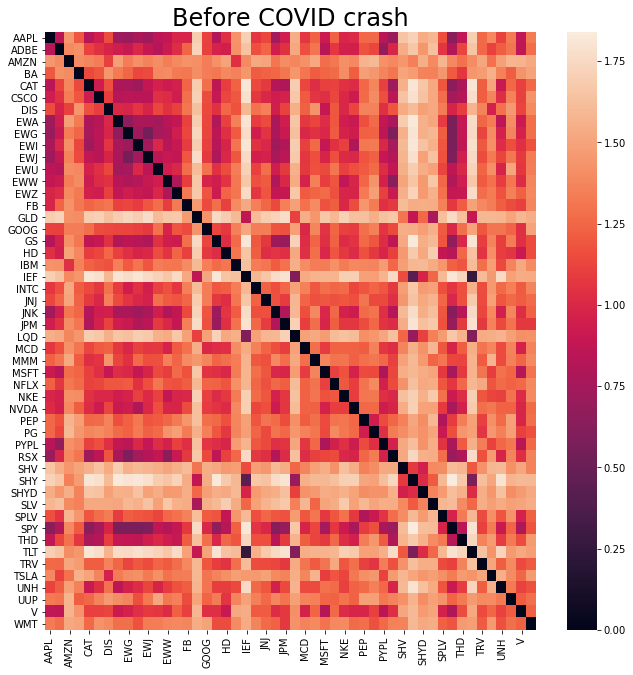

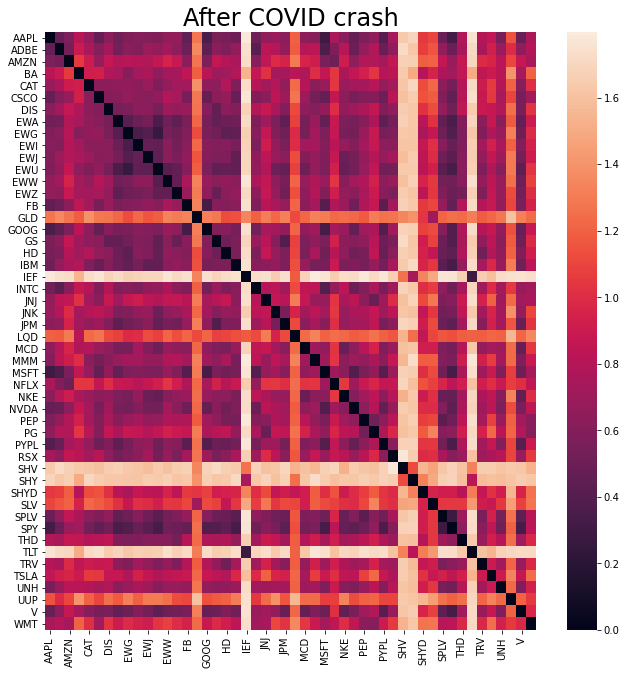

In [17]:
distances = []
i = 0
for close_prices in [close_prices_before_covid, close_prices_after_covid]:
    log_returns = np.log(close_prices / close_prices.shift(1))[1:]
    correlations = log_returns.corr()
    distance = np.sqrt(2 * (1 - correlations))
    distances.append(distance)
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(11, 11)
    if i == 0:
        title_prefix = "Before"
    else:
        title_prefix = "After"
    ax.set_title("{} COVID crash".format(title_prefix), fontsize=24)
    g = sns.heatmap(distance)
    i += 1
plt.show()

It can be seen that before the COVID crash, there was a great distance between the US broad market components and
precious metals/tresuries (denoted by the brighter colors in the first graph). After the COVID crash, we notice that
the distances between all assets decreased significantly. This indicates a greater correlation happening.

Next we obtain the MST for these networks.

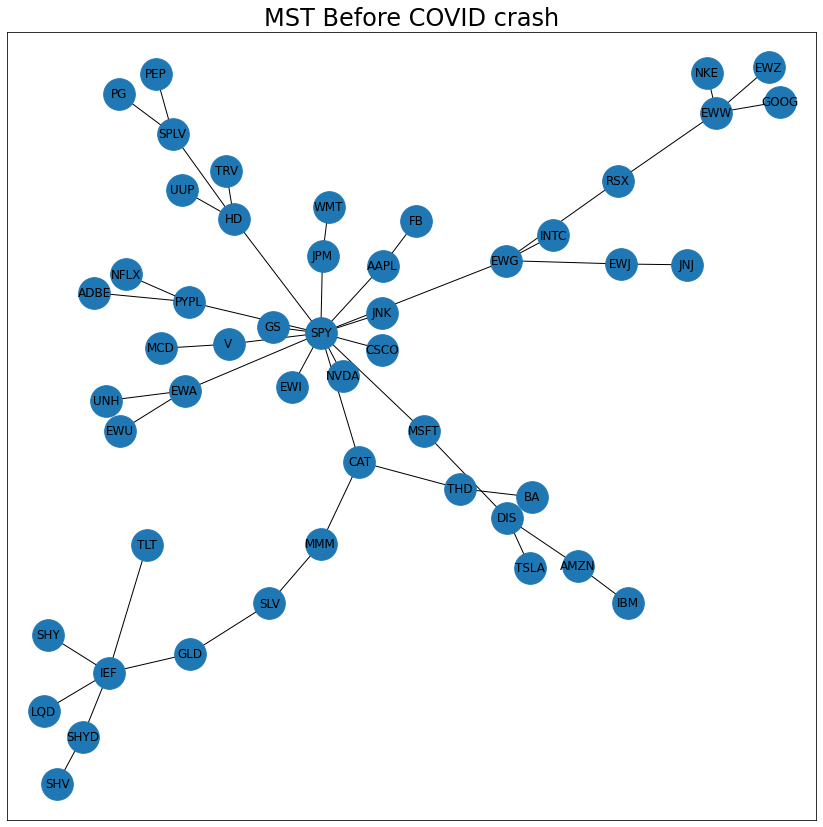

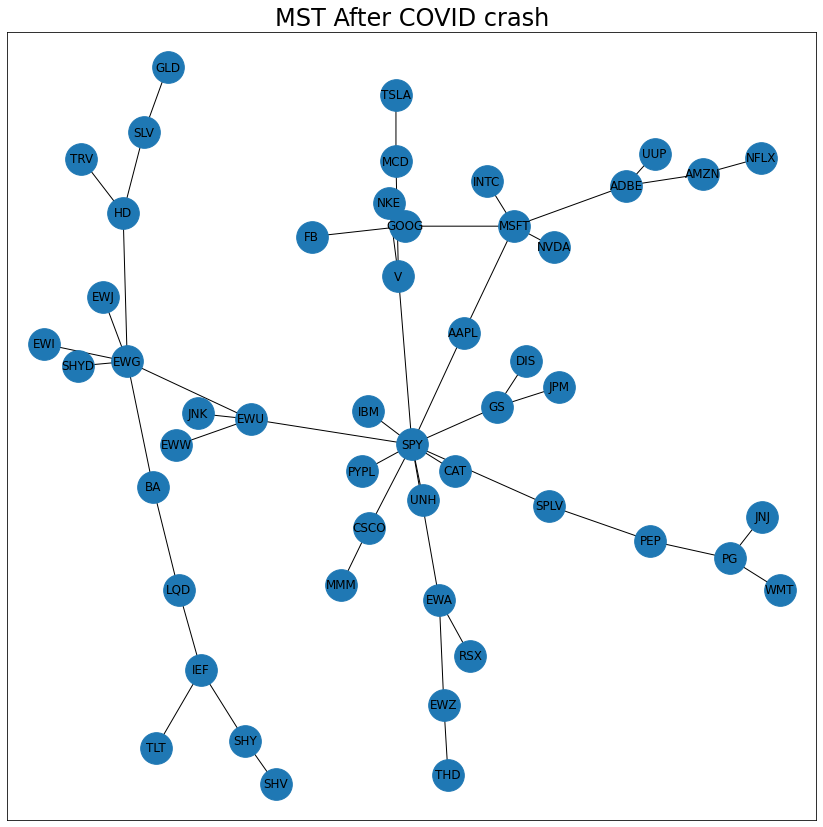

In [18]:
i = 0
for dist in distances:
    graph = Graph(dist)
    edges = graph.weighted_edges()
    nodes = graph.vertices()
    mst = graph.kruskal_mst()
    if i == 0:
        title_prefix = "Before"
    else:
        title_prefix = "After"
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(14.5, 14.5)
    draw_graph(nodes, mst, ax, graph_layout=nx.spring_layout, title="MST {} COVID crash".format(title_prefix))
    i += 1
plt.show()

We observe that before the COVID crash, the SPY (SP500) etf had a small separation between US stocks, and greater separation
between previous metals (GLD, SLV) and treasuries (IEF, TLT, SHY, etc.)

After the COVID crash, the distances from the SPY to US stocks, suggesting individual stocks had a stronger clustering
between each other rather than the broad market. It can also be observed a greater distance between treasuries (IEF, TLT)
and precious metals (GLD, SLV.) Before the crash these two clusters where direcly connected to each other, now they are
separated by multiple components. Suggesting there was a divergence between these two assets.

## Conclusion


[sources]: #sources
## Sources
[1] [A review of two decades of correlations, hierarchies, networks and clusteringin financial markets](https://arxiv.org/pdf/1703.00485.pdf)
<br>
[2] [Hierarchical Structure in Financial Markets](https://arxiv.org/pdf/cond-mat/9802256.pdf)